In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)
import pickle

import warnings
warnings.filterwarnings("ignore")
from dl import plot_loss


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_data()
# print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
display(train_df.head())
train_df.info()

train_df.head(10):
            Section/Products  33SectorName  17SectorName  Universe0  \
Date                                                                  
2017-01-04                 0             6             8          0   
2017-01-05                 0             6             8          0   
2017-01-06                 0             6             8          0   
2017-01-10                 0             6             8          0   
2017-01-11                 0             6             8          0   
2017-01-12                 0             6             8          0   
2017-01-13                 0             6             8          0   
2017-01-16                 0             6             8          0   
2017-01-17                 0             6             8          0   
2017-01-18                 0             6             8          0   

            MarketCapitalization  SecuritiesCode          RowId    Open  \
Date                                                 

,Section/Products,33SectorName,17SectorName,Universe0,MarketCapitalization,SecuritiesCode,RowId,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,,,,,,
2017-01-04,0,6,8,0,3.365911e+10,1301,20170104_1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-05,0,6,8,0,3.365911e+10,1301,20170105_1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
2017-01-06,0,6,8,0,3.365911e+10,1301,20170106_1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092
2017-01-10,0,6,8,0,3.365911e+10,1301,20170110_1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100
2017-01-11,0,6,8,0,3.365911e+10,1301,20170111_1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Section/Products      int64  
 1   33SectorName          int64  
 2   17SectorName          int64  
 3   Universe0             int64  
 4   MarketCapitalization  float64
 5   SecuritiesCode        int64  
 6   RowId                 object 
 7   Open                  float64
 8   High                  float64
 9   Low                   float64
 10  Close                 float64
 11  Volume                int64  
 12  AdjustmentFactor      float64
 13  ExpectedDividend      float64
 14  SupervisionFlag       bool   
 15  Target                float64
dtypes: bool(1), float64(8), int64(6), object(1)
memory usage: 287.0+ MB


# Create model

### Args and constants
* Adding financials wes cumbersome maybe not worth now to add that data


In [4]:

"""
SUBTRACT:
*) 3 FROM CONTINUOUS COLS BECAUSE OF POOLING
*) 1 FROM CAT_FEATURES TO MAKE MATRICES MATCH AFTER TORCH.CAT
"""
CONT_COLS=['Close', 'Open', 'High', 'Low', 'MarketCapitalization',         
           # 'NetSales', 'EquityToAssetRatio', 'TotalAssets', 'Profit', 
           # 'OperatingProfit', 'EarningsPerShare', 'Equity', 
           # 'BookValuePerShare', 'ResultDividendPerShare1stQuarter', 
           # 'ResultDividendPerShare2ndQuarter', 'ResultDividendPerShare3rdQuarter',
           # 'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual'
          ]
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 + 4 - 1 # TEXT_COLS = ['Section/Products', '33SectorName', '17SectorName', 'Universe0']
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 7


In [5]:

def create_model():
    model = None
    model = NeuralNetwork(
        in_features=TS_IN_FEATURES - 3, 
        units=128,
        out_features=1, 
        categorical_dim=CAT_FEATURES,
        no_embedding=NO_EMBEDDING, 
        emb_dim=EMBEDDING_DIM,
        n_blocks=4,
        n_stacks=1,
        dropout=0.3,
        pooling_sizes=3
    )

    print(model)
    return model

# Loop throug each stock
Create Trainer only once

In [6]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512
weight_decay = 0.1
EPOCHS = 1


scaler_dict = {}

model = create_model()

trainer = Trainer(
    model, 
    optimizer_name='rmsprop', 
    lr=1.3333e-5, 
    weight_decay=weight_decay
)

torch.autograd.set_detect_anomaly(True)

train_loss_list = []
train_mae_list = []
valid_loss_list = []
valid_mae_list = []


"""
SHUFFLE STOCKS WHEN TRAINING
"""
np.random.seed(0)

STOCK_EPOCH = 3
for s_epoch in range(STOCK_EPOCH):
    print('$' * 80)
    print('stock-epoch:', s_epoch)
    np.random.shuffle(stocks) # SHUFFLE STOCKS IN PLACE
    print(stocks)
    for no_stock, stock in enumerate(stocks[: 500]):
        try:
            train_loader, val_dataloader = None, None
            print(f'Stock-iteratation: {no_stock}')
            print(f'Start training for stock: {stock}')

            train_dataloader, val_dataloader, scaler = dataloader_by_stock(
                train_df, 
                stock, 
                batch_size=BATCH_SIZE, 
                continous_cols=CONT_COLS,
                return_scaler=True
            )
            # if count > 1:
            #     EPOCHS = 15
            train_loss, train_mae, val_loss, val_mae = trainer.fit_epochs(
                train_dataloader, 
                val_dataloader, 
                use_cyclic_lr=True, 
                x_cat=True, 
                epochs=EPOCHS
            )
            train_loss_list.extend(train_loss)
            train_mae_list.extend(train_mae)
            valid_loss_list.extend(val_loss)
            valid_mae_list.extend(val_mae)
            scaler_dict[stock] = scaler
            print('#' * 20)
            print()
            count += 1
        except Exception as e:
            print(f'Training loop: {e}')
    
trainer.save_model(model)
with open('scaler_dict.pkl', 'wb') as f:
    pickle.dump(scaler_dict, f)

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=128, bias=True)
  (embedding_output): Linear(in_features=128, out_features=1, bias=True)
  (cont_input): Linear(in_features=2, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pooling_layer): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=True)
  (stacks): ModuleList(
    (0): NeuralStack(
      (blocks): ModuleList(
        (0): NeuralBlock(
          (resnet_block): ModuleList(
            (0): FFResNetBlock(
              (layers): ModuleList(
                (0): Linear(in_features=135, out_features=135, bias=True)
                (1): Linear(in_features=135, out_features=135, bias=True)
                (2): Linear(in_features=135, out_features=135, bias=True)
              )
              (layernorm): LayerNorm((135,), eps=1e-05, elementwise_affine=True)
            )
            (1): FFResNetBlock(
              (lay

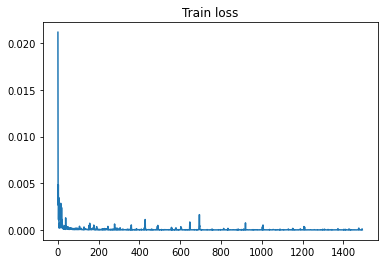

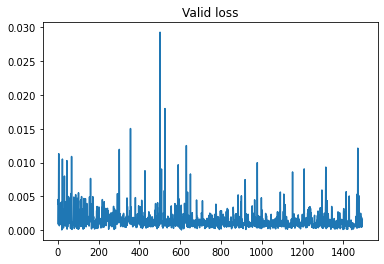

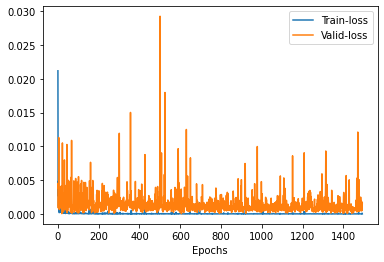

In [7]:
plt.plot(train_loss_list)
plt.title('Train loss');
plt.show()

plt.plot(valid_loss_list)
plt.title('Valid loss')
plt.show()

plot_loss(train_loss_list, valid_loss_list, 'Train-loss', 'Valid-loss')

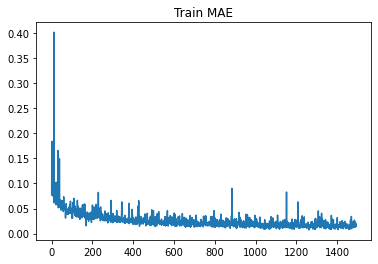

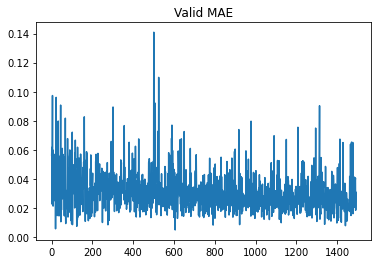

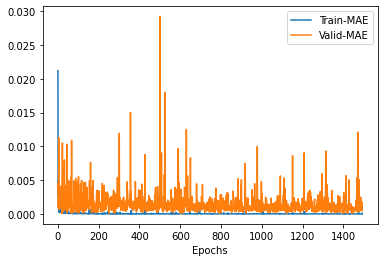

In [8]:
plt.plot(train_mae_list)
plt.title('Train MAE');
plt.show()

plt.plot(valid_mae_list)
plt.title('Valid MAE')
plt.show()

plot_loss(train_loss_list, valid_loss_list, 'Train-MAE', 'Valid-MAE')

In [9]:
train_loss_list[:5]

[0.021190533638000487,
 0.002667294144630432,
 0.004844104647636413,
 0.001103033646941185,
 0.0034636116027832032]

### 